In [7]:
import numba 
import pandas 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pprint import pprint

import ccxt
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
from datetime import datetime
from tqdm import tqdm
from IPython.display import display, HTML, Image
import requests
warnings.simplefilter('ignore')

### データのダウンロード

In [2]:
# Bybitのインスタンスを作成
bybit = ccxt.bybit()

def fetch_ohlcv(symbol, timeframe, start_time, end_time, limit=200):
    """
    BybitからOHLCVデータを取得
    start_timeとend_timeはミリ秒精度のタイムスタンプ
    """
    all_data = []
    since = start_time
    while True:
        # OHLCVデータを取得
        data = bybit.fetch_ohlcv(symbol, timeframe, since=since, limit=limit)
        if not data:
            # 取得できるデータがなくなったら終了
            break
        
        # end_timeを超えないデータを残す
        filtered_data = [d for d in data if d[0] <= end_time]
        all_data.extend(filtered_data)
        
        # 取得したデータの最後のtimestamp
        last_timestamp = data[-1][0]
        
        # end_timeを超えていたらループを抜ける
        if last_timestamp >= end_time:
            break
        
        # 次の取得開始位置を更新
        since = last_timestamp + 1
    
    df = pd.DataFrame(all_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    return df

def fetch_open_interest(symbol, interval_time, start_time, end_time):
    """
    Bybitから未決済建玉データをページネーションで全期間取得
    start_timeとend_timeはミリ秒精度のタイムスタンプ
    """
    base_url = "https://api.bybit.com/v5/market/open-interest"
    
    all_data_frames = []
    cursor = None
    
    while True:
        params = {
            "category": "linear",
            "symbol": symbol,
            "intervalTime": interval_time,
            "startTime": start_time,
            "endTime": end_time,
            "limit": 200
        }
        
        # カーソルがある場合はパラメータに追加
        if cursor:
            params["cursor"] = cursor
        
        response = requests.get(base_url, params=params)
        data = response.json()
        
        # データが正しく取得できなければ終了
        if "result" not in data or "list" not in data["result"] or not data["result"]["list"]:
            break
        
        # 一時的にDataFrame化してリストに追加
        part_df = pd.DataFrame(data["result"]["list"])
        all_data_frames.append(part_df)
        
        # 次ページのカーソルを取得
        next_cursor = data["result"].get("nextPageCursor", None)
        if not next_cursor:
            break
        
        cursor = next_cursor
    
    # 全ページを結合
    if all_data_frames:
        final_df = pd.concat(all_data_frames, ignore_index=True)
    else:
        final_df = pd.DataFrame()
    
    return final_df

# 取得パラメータの設定
symbol = "BTCUSDT"
timeframe = "1h"
start_date = "2024-01-01"
end_date = "2024-12-31"

# 日付をミリ秒タイムスタンプに変換
start_timestamp = int(datetime.strptime(start_date, "%Y-%m-%d").timestamp() * 1000)
end_timestamp = int(datetime.strptime(end_date, "%Y-%m-%d").timestamp() * 1000)

# OHLCVデータを取得
ohlcv_data = fetch_ohlcv(symbol, timeframe, start_time=start_timestamp, end_time=end_timestamp)
ohlcv_data["timestamp"] = pd.to_datetime(ohlcv_data["timestamp"], unit="ms")

# 未決済建玉データを取得
oi_data = fetch_open_interest(symbol, "1h", start_time=start_timestamp, end_time=end_timestamp)
if not oi_data.empty:
    oi_data["timestamp"] = pd.to_datetime(oi_data["timestamp"], unit="ms")

# マージ（timestamp列でinner join）
df = pd.merge(ohlcv_data, oi_data, on="timestamp", how="inner")
df["openInterest"] = df["openInterest"].astype(float)
df["openInterest_change"] = df["openInterest"] - df["openInterest"].shift(1)
df_raw = df.copy()
display(df)

,timestamp,open,high,low,close,volume,openInterest,openInterest_change
0,2024-01-01 00:00:00,42324.8,42610.9,42300.2,42517.4,3038.207,57333.868,NaN
1,2024-01-01 01:00:00,42517.4,42842.9,42475.1,42661.3,3308.231,57372.416,38.548
2,2024-01-01 02:00:00,42661.3,42691.9,42550.8,42631.8,1651.447,57110.981,-261.435
3,2024-01-01 03:00:00,42631.8,42641.4,42271.5,42384.1,3499.277,57163.047,52.066
4,2024-01-01 04:00:00,42384.1,42448.0,42250.5,42446.3,1800.157,57661.197,498.150
...,...,...,...,...,...,...,...,...
8756,2024-12-30 20:00:00,94387.1,95000.0,94243.5,94306.3,5724.868,64364.353,197.815
8757,2024-12-30 21:00:00,94306.3,94353.4,91831.4,92029.8,14356.379,64457.686,93.333
8758,2024-12-30 22:00:00,92029.8,93000.0,91887.6,92745.3,5322.142,63129.068,-1328.618
8759,2024-12-30 23:00:00,92745.3,92837.5,92312.5,92739.3,2838.746,62937.697,-191.371


### 清算ヒートマップを作成する関数

In [3]:
def make_heatmap(df, leverage=20, bins=50):
    
    #清算価格の計算
    df['entryPrice'] = (df['open'] + df['close']) / 2
    df['longLiquidationPrice'] = df['entryPrice'] * (1 - 1 / leverage)
    df['shortLiquidationPrice'] = df['entryPrice'] * (1 + 1 / leverage)
    df['timestamp_index'] = df.index

    #ヒートマップ用の配列を定義
    # 価格の最小値と最大値を取得
    price_max = df['shortLiquidationPrice'].max() * 1.1
    price_min = df['longLiquidationPrice'].min() * 0.9

    # 価格のビンを作成
    bin_edges = np.linspace(price_min, price_max, bins)
    map = np.column_stack((bin_edges[:-1], bin_edges[1:]))

    timestamp = df["timestamp_index"].to_numpy()
    close = df["close"].to_numpy()

    # 各価格セルに timestamp,close を行方向に展開
    # 各セルを timestamp 数分複製
    map_expanded = np.repeat(map, len(timestamp), axis=0) 
    timestamps_expanded = np.tile(timestamp, map.shape[0]) 
    close_expanded = np.tile(close, map.shape[0])  
    map = np.column_stack((map_expanded, timestamps_expanded, close_expanded))

    # 追加列を0に設定（OIの累積値を格納する用）
    map = np.column_stack((map, np.zeros(map.shape[0])))

    # 追加列をもう1つ設定し、closeが価格セルに重なるかどうかをラベリング
    map = np.column_stack((map, np.zeros(map.shape[0])))
    cond = (map[:,3] >= map[:,0]) & (map[:,3] < map[:,1])
    map[cond, 5] = 1

    # 全てのtimestampについて、ロングの清算価格とショートの清算価格にOIの変化量の累積格納
    for i in range(1,len(timestamp)):
        llp = df["longLiquidationPrice"].iloc[i]
        slp = df["shortLiquidationPrice"].iloc[i]
        oi_change = df["openInterest_change"].iloc[i]
        # 前の時刻 i-1 のスライスをコピーして、i の行へ書き込む
        map[map[:,2] == i, 4] = map[map[:,2] == i-1, 4]
        # ロング部分の更新
        map[(map[:,0] < llp) & (map[:,1] > llp) & (map[:,2] == i), 4] += oi_change
        # ショート部分の更新
        map[(map[:,0] < slp) & (map[:,1] > slp) & (map[:,2] == i), 4] += oi_change
        #closeが重なるセルのoi累積値を0にリセット
        map[(map[:,5] == 1) & (map[:,2] == i), 4] = 0

    
    #可視化
    # データの抽出
    x = map[:, 0]  # 価格
    y = map[:, 2]  # 時間
    values = map[:, 4]  # ヒートマップ用の値

    # グリッドサイズを
    x_bins = np.linspace(x.min(), x.max(), bins)
    y_bins = np.linspace(y.min(), y.max(), len(timestamp))

    # 2Dヒストグラムを作成
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=[x_bins, y_bins], weights=values)

    # ヒートマップの描画
    plt.figure(figsize=(20, 5))
    plt.imshow(heatmap, origin='lower', aspect='auto',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]])
    plt.colorbar(label='Value')
    plt.xlabel('Column 1 (Vertical)')
    plt.ylabel('Column 3 (Horizontal)')
    plt.title('Heatmap with Overlayed Mean Values')

    ## 平均値の計算と折れ線グラフの描画
    mean_vals = []
    for i in range(len(y_bins) - 1):
        mask = (map[:, 2] >= y_bins[i]) & (map[:, 2] < y_bins[i + 1])
        mean_val = map[mask, 3].mean() if np.any(mask) else 0
        mean_vals.append(mean_val)

    plt.plot(y_bins[:-1], mean_vals, color='black', label='Close')

    # 凡例の追加
    plt.legend(loc='upper right')

    # 表示
    plt.grid(False)
    plt.show()    
    

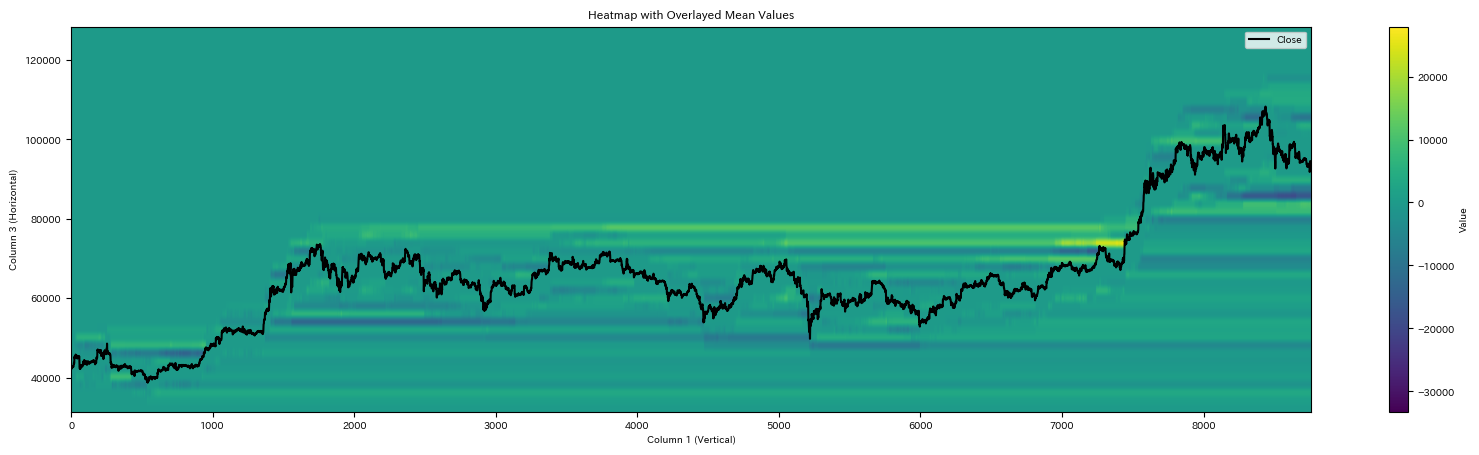

In [4]:
make_heatmap(df, 10, 50)

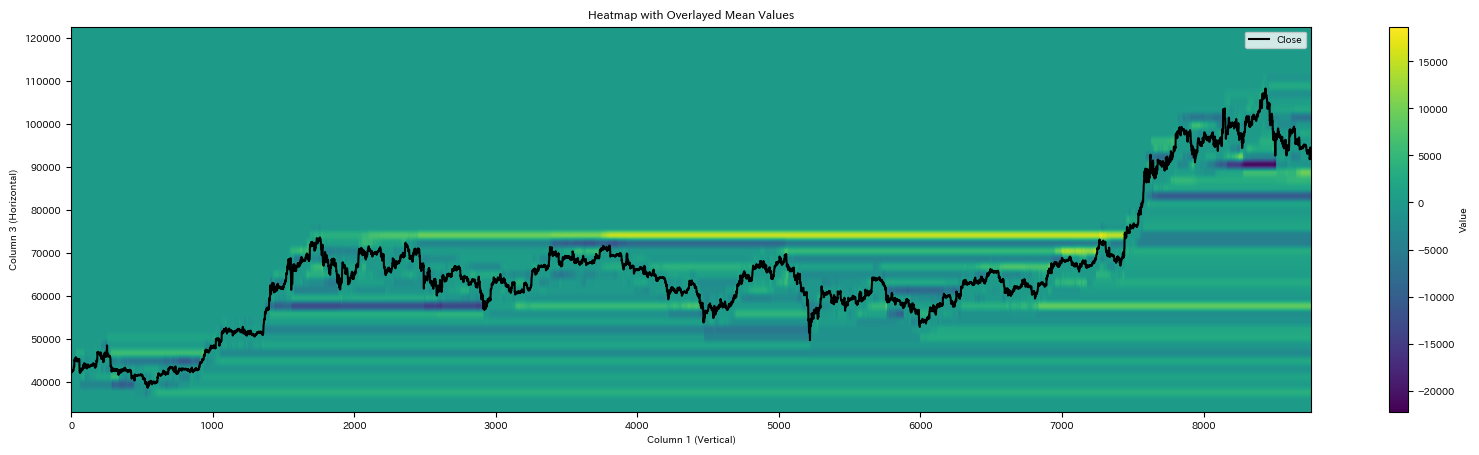

In [5]:
make_heatmap(df, 20, 50)

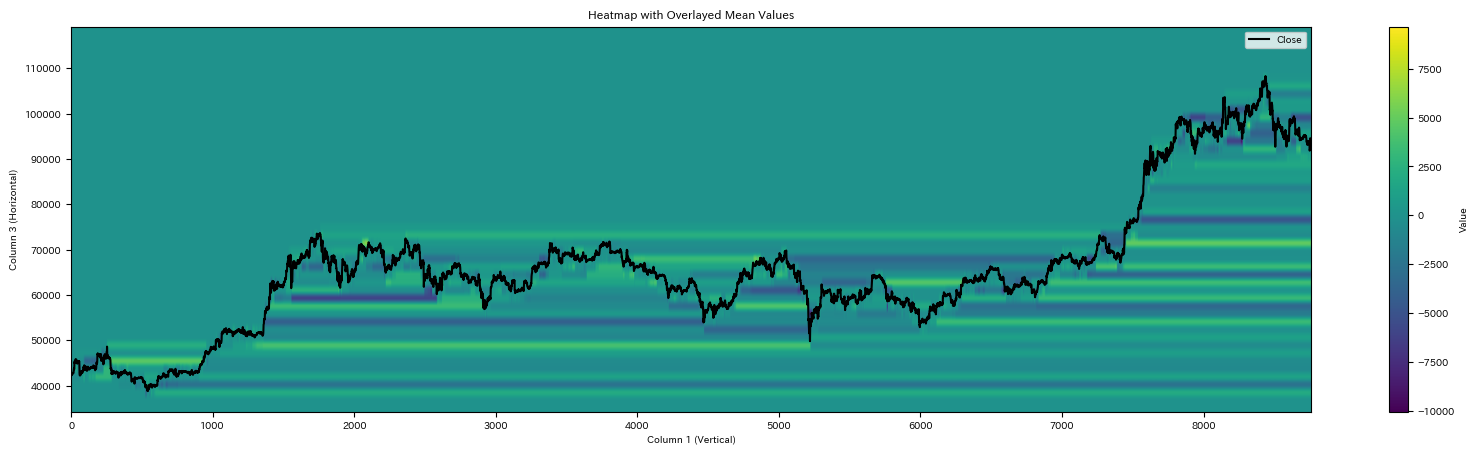

In [6]:
make_heatmap(df, 50, 50)